In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import gfile
import imageio
import pickle
import scipy.misc
import sys
from IPython.display import HTML
import imageio
import skvideo.io
slim = tf.contrib.slim
from nets import inception_v3
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
videos = gfile.Glob("/home/andrewliu/research/viewpoint/train/strikebig/videos/*.mp4")
# videos = pickle.load(open('videolist.pkl', 'rb'))
idata = [[] for _ in range(25)]
nfail = 0
idim = (299, 299)
itr = 0
np.random.shuffle(videos)
for name in videos[:100]:
    try:
        vid = imageio.get_reader(name,  'ffmpeg')
        if itr % 100 == 0:
            print(itr, map(len, idata))
#         if itr % 1000 == 0:
#             vdata = np.array(idata)
#             np.save('vdata_reach_distract'+str(itr), vdata)
        if len(vid) == 51:
            frames = []
            for j in range(1, 51, 2):
                frame = scipy.misc.imresize(vid.get_data(j), idim)
                if np.max(frame) == 0:
                    print("rip", itr, name)
                    frames = []
                    break
                frames.append(frame)
            if len(frames) != 25:
                continue
            for j, f in enumerate(frames):
                idata[j].append(f)
        else:
            print(name, len(vid))
        itr += 1
    except:
        nfail += 1
        print("Unexpected error:", sys.exc_info())
        print(name)
        if nfail > 10:
            break
vdata = np.array(idata)
# np.save('vdata_strike'+str(itr), vdata)
vdata.shape

0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(25, 100, 299, 299, 3)

In [3]:
vdata.shape

(25, 100, 299, 299, 3)

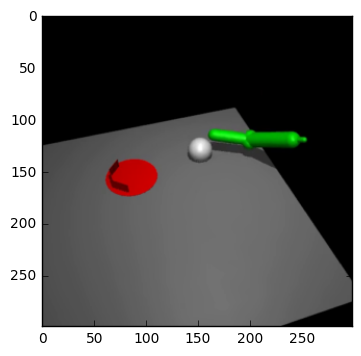

In [4]:
plt.imshow(vdata[8][4])

In [5]:
vdata.shape

(25, 100, 299, 299, 3)

In [6]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                  initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    return conv
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon  = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):
        return tf.contrib.layers.batch_norm(x,
                      decay=self.momentum, 
                      updates_collections=None,
                      epsilon=self.epsilon,
                      scale=True,
                      is_training=tftrain,
                      scope=self.name)
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
              initializer=tf.constant_initializer(bias_start))
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias
    

def deconv2d(input_, output_shape,
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                  initializer=tf.random_normal_initializer(stddev=stddev))

        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

In [7]:
class ContextAE:
    def __init__(self, gf_dim=64, df_dim=64,
                 gfc_dim=1024, dfc_dim=1024):
        self.gf_dim = gf_dim
        self.df_dim = df_dim
#         self.c_dim = c_dim

        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim


    def build(self, image):
        imgshape = image.get_shape().as_list()
        print(imgshape)
        self.output_height, self.output_width, self.c_dim = imgshape[-3:]
        self.batch_size = imgshape[1]
        featsize = 1024
        srcimg = image[0]
        tgtimg = image[2]
        tgtctx = image[1]
        
        with tf.variable_scope("conv_context") as scope:
            tgtctx_h0 = lrelu(conv2d(tgtctx, self.df_dim, name='h0_conv'))
            tgtctx_h1 = lrelu(conv2d(tgtctx_h0, self.df_dim*2, name='h1_conv'))
            tgtctx_h2 = lrelu(conv2d(tgtctx_h1, self.df_dim*4, name='h2_conv'))
            tgtctx_h3 = lrelu(conv2d(tgtctx_h2, self.df_dim*8, name='h3_conv'))
            tgtctx_h4 = lrelu(linear(tf.reshape(tgtctx_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            tgtctx_z = linear(tgtctx_h4, featsize, 'hz_lin')

        with tf.variable_scope("conv") as scope:
            srcimg_h0 = lrelu(conv2d(srcimg, self.df_dim, name='h0_conv'))
            srcimg_h1 = lrelu(conv2d(srcimg_h0, self.df_dim*2, name='h1_conv'))
            srcimg_h2 = lrelu(conv2d(srcimg_h1, self.df_dim*4, name='h2_conv'))
            srcimg_h3 = lrelu(conv2d(srcimg_h2, self.df_dim*8, name='h3_conv'))
            print(srcimg_h3.get_shape())
            srcimg_h4 = lrelu(linear(tf.reshape(srcimg_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            srcimg_z = lrelu(linear(srcimg_h4, featsize, 'hz_lin'))
            
            scope.reuse_variables()
            
            tgtimg_h0 = lrelu(conv2d(tgtimg, self.df_dim, name='h0_conv'))
            tgtimg_h1 = lrelu(conv2d(tgtimg_h0, self.df_dim*2, name='h1_conv'))
            tgtimg_h2 = lrelu(conv2d(tgtimg_h1, self.df_dim*4, name='h2_conv'))
            tgtimg_h3 = lrelu(conv2d(tgtimg_h2, self.df_dim*8, name='h3_conv'))
            tgtimg_h4 = lrelu(linear(tf.reshape(tgtimg_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            tgtimg_z = lrelu(linear(tgtimg_h4, featsize, 'hz_lin'))

        with tf.variable_scope("translate") as scope:
            trans_h0 = lrelu(linear(tf.concat([srcimg_z, tgtctx_z], 1), featsize, 'trans_h0'))
            trans_z = linear(trans_h0, featsize, 'trans_z')
            self.translated_z = trans_z
        
        with tf.variable_scope("deconv") as scope:
            s_h, s_w = self.output_height, self.output_width
#             s_h2, s_h4, s_h8, s_h16 = \
#                 int(s_h/2), int(s_h/4), int(s_h/8), int(s_h/16)
#             s_w2, s_w4, s_w8, s_w16 = \
#                 int(s_w/2), int(s_w/4), int(s_w/8), int(s_w/16)
            _, s_h2, s_w2, _ = tgtctx_h0.get_shape().as_list()
            _, s_h4, s_w4, _ = tgtctx_h1.get_shape().as_list()
            _, s_h8, s_w8, _ = tgtctx_h2.get_shape().as_list()
            _, s_h16, s_w16, _ = tgtctx_h3.get_shape().as_list()
    
            output_z_ = lrelu(linear(trans_z, self.gf_dim*8*s_h16*s_w16, 'd_h0_lin'))
            output_h0 = tf.reshape(output_z_, [-1, s_h16, s_w16, self.gf_dim * 8])
            output_h1 = lrelu(deconv2d(tf.concat([output_h0, tgtctx_h3], 3),
                    [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='d_h1'))
            output_h2 = lrelu(deconv2d(tf.concat([output_h1, tgtctx_h2], 3),
                [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='d_h2'))
            output_h3 = lrelu(deconv2d(tf.concat([output_h2, tgtctx_h1], 3),
                [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='d_h3'))
            output_h4 = deconv2d(tf.concat([output_h3, tgtctx_h0], 3),
                [self.batch_size, s_h, s_w, self.c_dim], name='d_h4')
            
            scope.reuse_variables()
            
            truthoutput_z_ = lrelu(linear(tgtimg_z, self.gf_dim*8*s_h16*s_w16, 'd_h0_lin'))
            truthoutput_h0 = tf.reshape(truthoutput_z_, [-1, s_h16, s_w16, self.gf_dim * 8])
            truthoutput_h1 = lrelu(deconv2d(tf.concat([truthoutput_h0, tgtctx_h3], 3),
                    [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='d_h1'))
            truthoutput_h2 = lrelu(deconv2d(tf.concat([truthoutput_h1, tgtctx_h2], 3),
                [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='d_h2'))
            truthoutput_h3 = lrelu(deconv2d(tf.concat([truthoutput_h2, tgtctx_h1], 3),
                [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='d_h3'))
            truthoutput_h4 = deconv2d(tf.concat([truthoutput_h3, tgtctx_h0], 3),
                [self.batch_size, s_h, s_w, self.c_dim], name='d_h4')

        self.simloss = tf.reduce_mean((trans_z - tgtimg_z) ** 2) * 1e3
        mean, var = tf.nn.moments(tgtimg_z, axes=[0])
        print(var.get_shape())
#         self.simloss /= tf.reduce_mean(var)
        print(tgtimg_z.get_shape())
        self.out = output_h4# + contextimg#tf.nn.tanh(h4)
        self.out2 = truthoutput_h4
        self.recon1 = tf.nn.l2_loss(tgtimg - self.out)
        self.recon2 = tf.nn.l2_loss(tgtimg - self.out2)
        self.loss = self.recon1 + self.recon2 + self.simloss

In [21]:
tf.reset_default_graph()
batch_size = 25
idims = (299, 299)
tfimage = tf.placeholder(tf.uint8, (3, batch_size, ) + idims + (3, ), name='image')
image_trans = tf.image.convert_image_dtype(tf.reshape(tensor=tfimage, shape=(3 *batch_size, ) + idims + (3, )), dtype=tf.float32)
image_trans = tf.subtract(image_trans, 0.5)
image_trans = tf.multiply(image_trans, 2.0)
with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    model = inception_v3.inception_v3(image_trans, num_classes=1001, is_training=False, dropout_keep_prob=1.0)

In [22]:
variables_to_restore = slim.get_variables_to_restore()
restorer = tf.train.Saver(variables_to_restore)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# sess.run(tf.global_variables_initializer())

dtype('uint8')

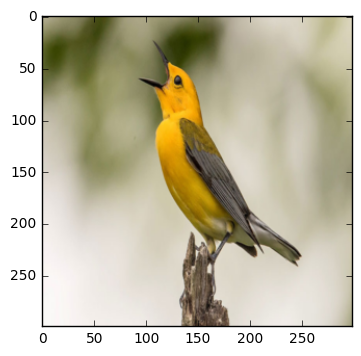

In [23]:
bird = scipy.misc.imread('inception/bird.jpg')
bird = scipy.misc.imresize(bird, idims)
plt.imshow(bird)
bird.dtype

In [24]:
# tf.reset_default_graph()
# idim = (64, 64)
tftrain = tf.placeholder(tf.bool, name='tftrain')
# batch_size=100
# tfinput = tf.placeholder(tf.float32, (3, batch_size) + idim + (3, ), name='x')
test = ContextAE()
featlayer = model[1]['Mixed_5d']
featshape = featlayer.get_shape().as_list()
featreshape = tf.reshape(featlayer, (3, batch_size, featshape[1], featshape[2], featshape[3]) )
with tf.variable_scope("contextmodel") as scope:
    test.build(featreshape)

[3, 25, 35, 35, 288]
(25, 3, 3, 512)
(1024,)
(25, 1024)


In [25]:
nn_err = tf.reduce_sum(tf.abs(tf.argmin(tf.reduce_mean((featreshape[2][:, None]-test.out)**2, axis=(2,3,4)), axis=0) - np.arange(0, 25)))

In [27]:
config = tf.ConfigProto(
#     device_count = {'GPU': 0}
                       )
# config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
learning_rate = tf.placeholder(tf.float32, shape=[])

train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "contextmodel")
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(test.loss, var_list=train_vars)
sess.run(tf.global_variables_initializer())
allloss = []
validloss = []
itr = 0
saver = tf.train.Saver()
restorer.restore(sess, "./inception/inception_v3.ckpt")

INFO:tensorflow:Restoring parameters from ./inception/inception_v3.ckpt


In [33]:
logits = sess.run(model[0], {tfimage:[[bird]*batch_size]*3})
print(logits.shape)
np.argsort(logits[0])[-20:]

(75, 1001)


array([ 88,  97,  91, 883, 326, 990, 952, 913,  14,  15,  20,  11,  17,
        13,  21,  93,  96,  95,  16,  12])

In [15]:
# new_saver = tf.train.import_meta_graph('viewpoint1000-DSG4239.meta')
# new_saver.restore(sess, 'viewpoint1000-DSG4239')

In [32]:
vid = imageio.get_reader('/home/andrewliu/research/viewpoint/train/strikebig/videos/openaigym.video.1456.26585.video000000.mp4',  'ffmpeg')
frame = scipy.misc.imresize(vid.get_data(0), idims)
layersout = sess.run(model[1]['Mixed_5d'], {tfimage:[[frame]*25]*3})
np.max(layersout)

9.5781527

In [16]:
# saver.restore(sess, './ctxskipstartgoalvpdistract46349')
saver.restore(sess, './strike_vp_inception2749')

INFO:tensorflow:Restoring parameters from ./strike_vp_inception2749


In [24]:
saver.save(sess, 'strike_vp_inception'+str(itr))

'strike_vp_inception2749'

In [10]:
np.sum(np.max(np.max(np.max(vdata, axis=-1), axis=-1), axis=-1)==-1)

0

In [34]:
print(vdata.shape)
n = vdata.shape[1]
ntrain = 80
nvalid = n - ntrain
print(ntrain, nvalid)
validdata = vdata[:, ntrain:]
traindata = vdata[:, :ntrain]
print(validdata.shape, traindata.shape)
while True:
    choicesrc = np.random.choice(ntrain, batch_size)
    choicetgt = np.random.choice(ntrain, batch_size)
    srcdata = traindata[np.arange(0, batch_size) % 25, choicesrc]
    tgtdata = traindata[np.arange(0, batch_size) % 25, choicetgt]
    tgtctx = traindata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    
#     print(sess.run( [test.recon1, test.recon2, test.loss, test.simloss], {tfinput: batch, learning_rate:1e-4, tftrain:False}))
    _, loss, sim, r1, r2, err = sess.run( [optimizer, test.loss, test.simloss, test.recon1, test.recon2, nn_err],
                                    {tfimage: batch, learning_rate:1e-4, tftrain:False})
    if itr % 4 == 0:
        print(loss, sim, r1, r2, err)
        allloss.append(loss)
    
    if itr % 40 == 0:
        choicesrc = np.random.choice(nvalid, batch_size)
        choicetgt = np.random.choice(nvalid, batch_size)
        srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
        tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
        tgtctx = validdata[0, choicetgt]
        batch = [srcdata, tgtctx, tgtdata]
        loss, sim, r1, r2, err = sess.run([test.loss, test.simloss, test.recon1, test.recon2, nn_err],
                                     {tfimage: batch, tftrain:False})
#         err = sess.run(nn_err,{tfimage: batch, tftrain:False})
        print(loss, sim, r1, r2, err, 'E')
        validloss.append(loss)
    itr += 1

(25, 100, 299, 299, 3)
80 20
(25, 20, 299, 299, 3) (25, 80, 299, 299, 3)
718109.0 8.8508 359074.0 359026.0 38
714006.0 8.48497 357020.0 356977.0 69
717433.0 9.17158 358737.0 358687.0 20
711470.0 9.51159 355750.0 355711.0 12
705338.0 9.61704 352692.0 352637.0 25
703243.0 9.39488 351643.0 351590.0 15
684160.0 9.21176 342118.0 342033.0 66
690824.0 10.0613 345441.0 345373.0 36
667807.0 9.01466 333916.0 333882.0 12
696832.0 10.8012 348427.0 348394.0 15
686201.0 9.67233 343114.0 343078.0 86 E
667601.0 11.1184 333824.0 333765.0 32
672319.0 10.7324 336188.0 336120.0 25
674414.0 11.1007 337235.0 337168.0 34
676503.0 10.3517 338277.0 338216.0 80
653862.0 11.1501 326956.0 326894.0 11
665402.0 11.48 332721.0 332669.0 51
682041.0 12.1513 341057.0 340971.0 8
671388.0 11.952 335723.0 335653.0 30
661313.0 11.8865 330677.0 330624.0 3
644657.0 11.5453 322356.0 322289.0 57
652993.0 10.4852 326525.0 326458.0 73 E
649392.0 12.3778 324719.0 324661.0 19
637387.0 12.0733 318728.0 318647.0 51
680724.0 12.3249 

KeyboardInterrupt: 

In [24]:
imgs = []
for kk in range(10):
    choicesrc = [np.random.randint(nvalid)] * batch_size
    choicetgt = [np.random.randint(nvalid)] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    L, r1, r2, testouts2, testouts, nearest, features = sess.run([test.loss, test.recon1, test.recon2, test.out2, test.out, nn_pred, featreshape], {tfimage: batch, tftrain: False})

#     i1 = "gif/__out%d.gif"%kk
#     savegif(i1, testouts[:25])
#     imgs.append(i1)
# #     imgs =[i1, i2, i3]
# #     disimgs(imgs)

    print(L, r1, r2, nearest)
#     filmstrip(srcdata[:25], 'fig/reachsrc%d.jpg'%itrand)
#     filmstrip(testouts[:25], 'fig/reachtrans%d.jpg'%itrand)
#     writevideo("videos/reach/trans/%dsrc.mp4" %itrand, srcdata[:25])
#     writevideo("videos/reach/trans/%dtrans.mp4" %itrand, testouts[:25])
#     scipy.misc.imsave('videos/reach/trans/%dctx.png'%itrand, toint(tgtdata[0]))
    # fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
    # for i in range(25):
    #     axx = ax[i//5][i%5]
    #     axx.imshow(inverse_transform(testouts2[i]))
    #     axx.axis('off')
    # plt.tight_layout()


    # fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
    # for i in range(25):
    #     axx = ax[i//5][i%5]
    #     axx.imshow(inverse_transform(testouts[i]))
    #     axx.axis('off')
    # plt.tight_layout()

    # fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
    # for i in range(25):
    #     axx = ax[i//5][i%5]
    #     axx.imshow(inverse_transform(tgtdata[i]))
    #     axx.axis('off')
    # plt.tight_layout()
    # for k in range(25):
    #     plt.figure()
    #     plt.imshow(inverse_transform(tgtdata[k]))
    #     plt.figure()
    #     plt.imshow(inverse_transform(testouts[k]))

5654.19 2826.94 2827.25 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
6179.73 3089.69 3090.03 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
6179.73 3089.7 3090.04 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
3947.31 1973.51 1973.81 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
4880.95 2440.3 2440.65 [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
3877.43 1938.57 1938.85 [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23]
4973.39 2486.48 2486.9 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
6179.73 3089.7 3090.03 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
3877.42 1938.56 1938.85 [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23]
4644.43 2322.07 2322.35 [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


1700

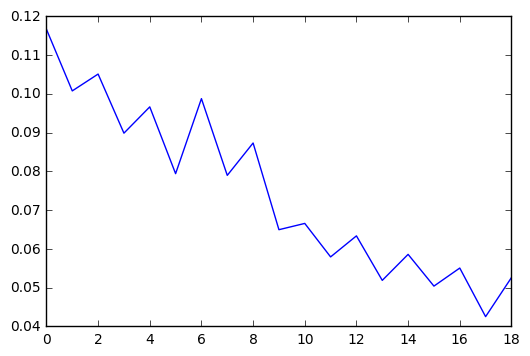

In [21]:
plt.plot(validloss[50:])

In [24]:
# np.save('reachdata_valid', validdata)
np.save('strikedata_train', traindata[:, :200])

In [47]:
nvalid
itrand = 0

In [13]:
def filmstrip(video, name, skip=5):
    fig, ax = plt.subplots(nrows=1, ncols=video.shape[0]//skip, figsize=(20,4))
    for i in range(video.shape[0]//skip):
        axx = ax[i]
        axx.imshow(np.clip(inverse_transform(video[i*skip]), 0, 1))
        axx.axis('off')
    plt.tight_layout()
    plt.savefig(name)
    # plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

In [48]:
def toint(frame):
    return scipy.misc.imresize((np.clip(inverse_transform(frame), 0, 1) * 255).astype(np.uint8), 
                          (frame.shape[0] * 10, frame.shape[1] * 10), interp='nearest')
def writevideo(name, data):
    rate = "10"
    writer = skvideo.io.FFmpegWriter(name, inputdict={
          '-r': rate,
        },
        outputdict={
          '-r': rate,
    })
    for i in xrange(data.shape[0]):
        writer.writeFrame(toint(data[i]))
    writer.close()

In [20]:
def savegif(name, frames):
    with imageio.get_writer(name, mode='I') as writer:
        for f in frames:
            writer.append_data((np.clip(inverse_transform(f),0,1)*255).astype(np.uint8))
def disimgs(imgs):
    strs = ''
    for img in imgs:
        strs += '<img src="%s?rand=%f" width="200px"/><br/>'%(img, np.random.rand())
    return HTML(strs)

In [90]:
np.sum((features[2][0] - features[0][23])**2)

1.0528202e-05

In [96]:
np.max(features)

0.0033076839

In [91]:
inc_strike = np.load('strike_inception.npz')
inc_strike.keys()

['Mixed_5dstd',
 'Mixed_5d',
 'Mixed_7bstd',
 'Mixed_6astd',
 'Mixed_5cstd',
 'Mixed_7a',
 'Mixed_7c',
 'Mixed_7b',
 'Mixed_6cstd',
 'Mixed_5c',
 'Mixed_5b',
 'Mixed_7cstd',
 'Mixed_6estd',
 'Mixed_5bstd',
 'Mixed_6bstd',
 'Mixed_7astd',
 'Mixed_6b',
 'Mixed_6c',
 'Mixed_6a',
 'Mixed_6d',
 'Mixed_6e',
 'Mixed_6dstd']

In [92]:
mean_strike = inc_strike['Mixed_5d']
std_strike = inc_strike['Mixed_5dstd']

In [95]:
np.mean(std_strike)

0.23794657

In [99]:
testfeats = sess.run(image_trans, {tfimage:batch})

In [25]:
testouts.shape, features.shape

((25, 35, 35, 288), (3, 25, 35, 35, 288))

In [28]:
testdiff = (features[2][:, None] - features[2])**2
testdiff.shape

(25, 25, 35, 35, 288)

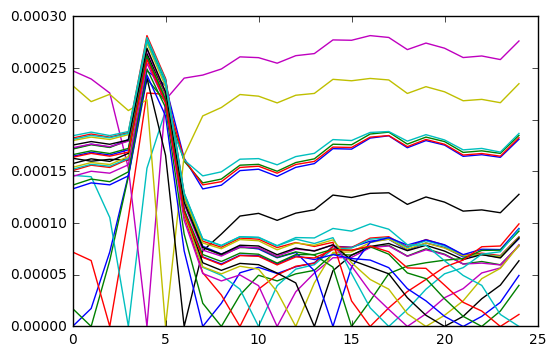

In [29]:
plt.plot(np.mean((features[2][:, None] - features[2])**2, axis=(2,3,4)))

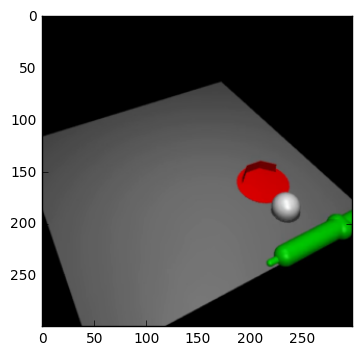

In [104]:
plt.imshow(testfeats[0]/2+0.5)

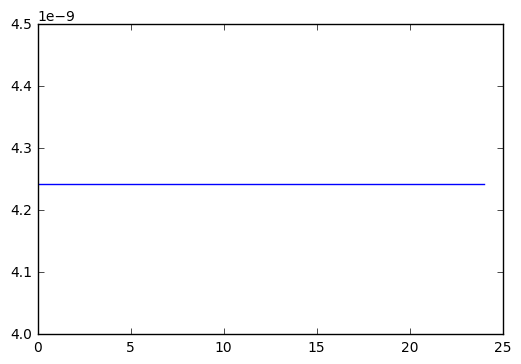

In [72]:
plt.plot(np.mean((features[2] - testouts[9])**2, axis=(1,2,3)))

In [34]:
data = (inverse_transform(srcdata[i, :, :, :]) * 255).astype(np.uint8)

In [36]:
data.shape

(48, 48, 3)

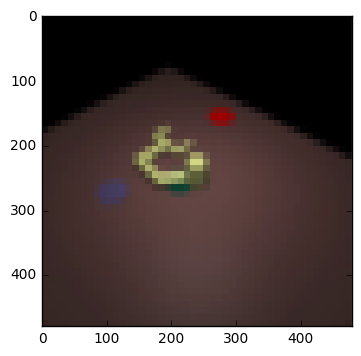

In [40]:
plt.imshow(scipy.misc.imresize(data, (480, 480), interp='nearest'), interpolation='none')

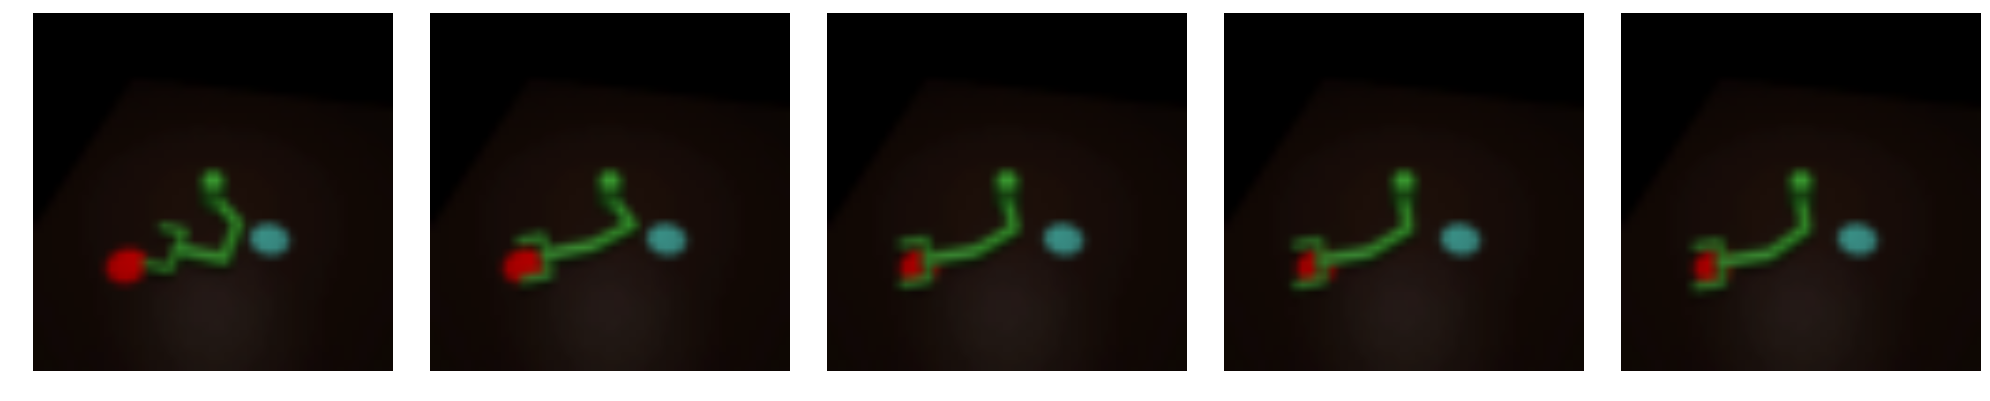

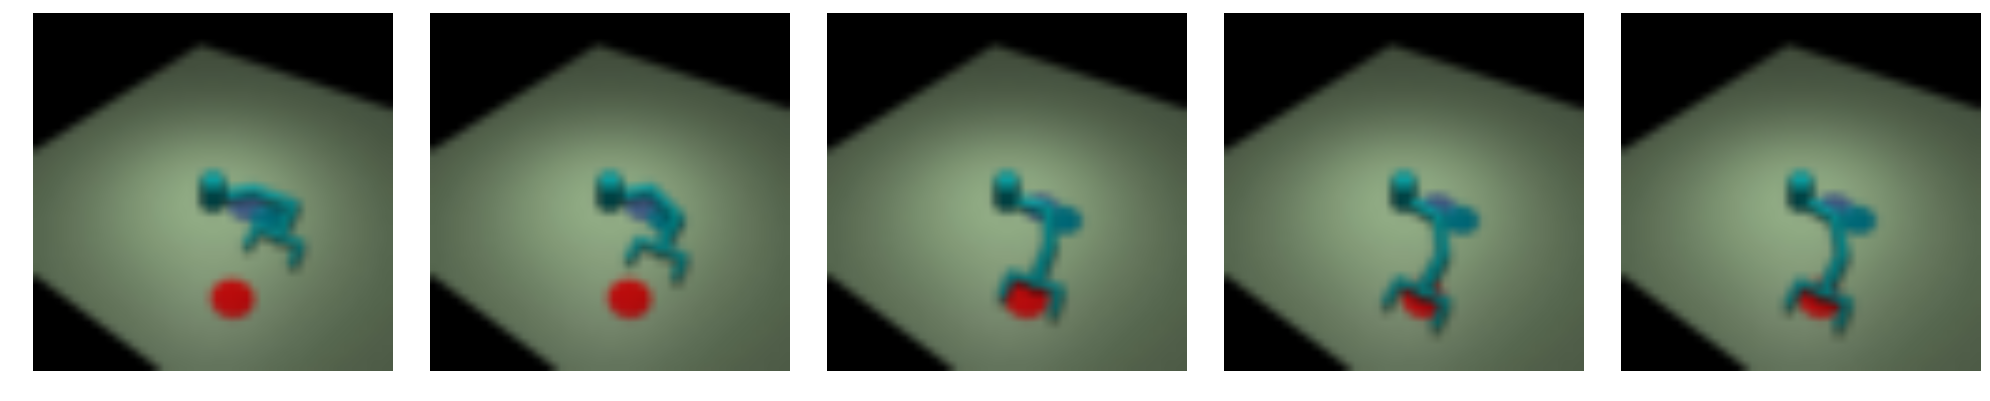

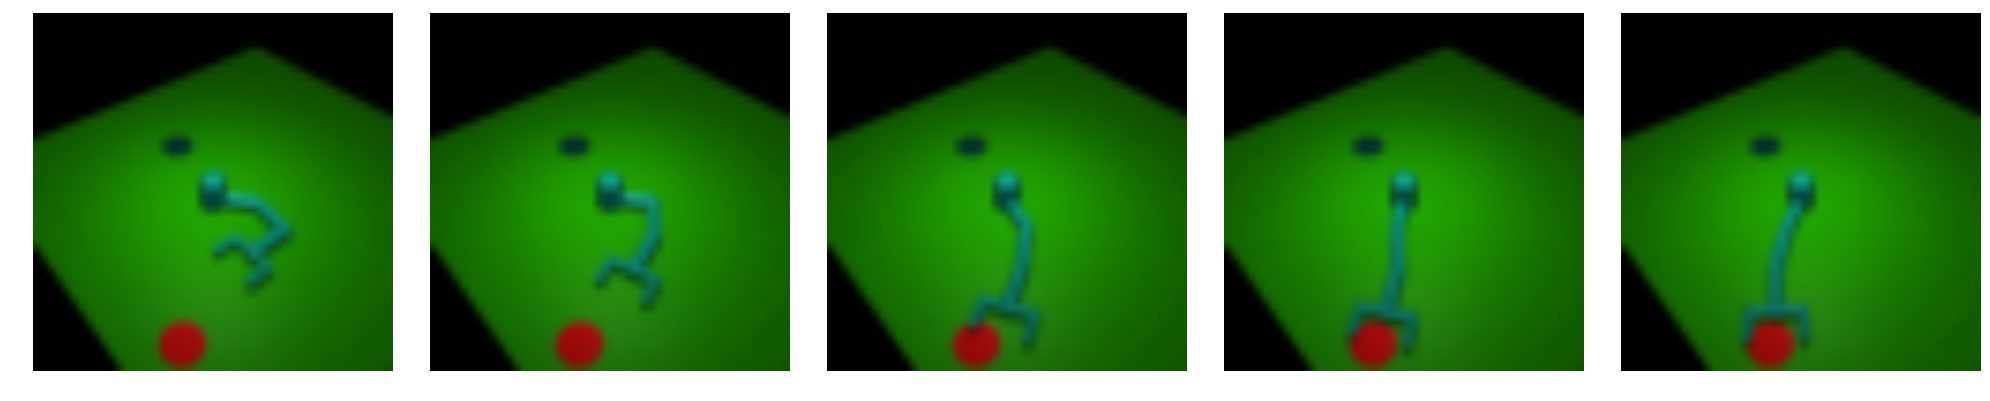

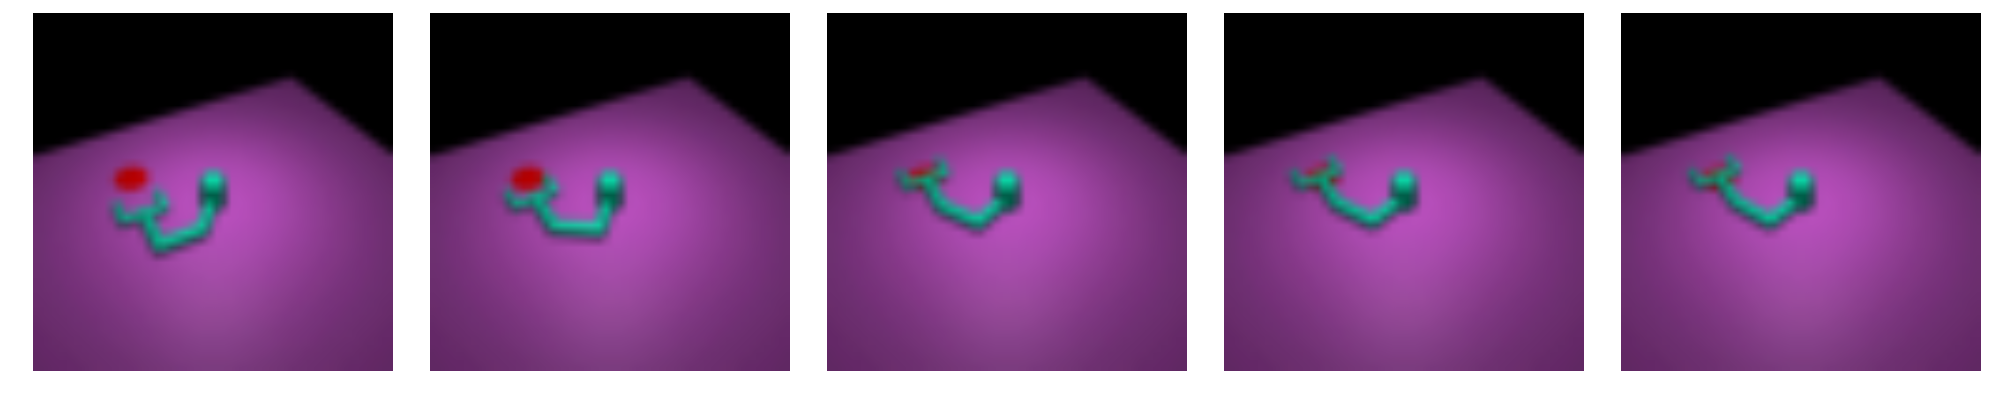

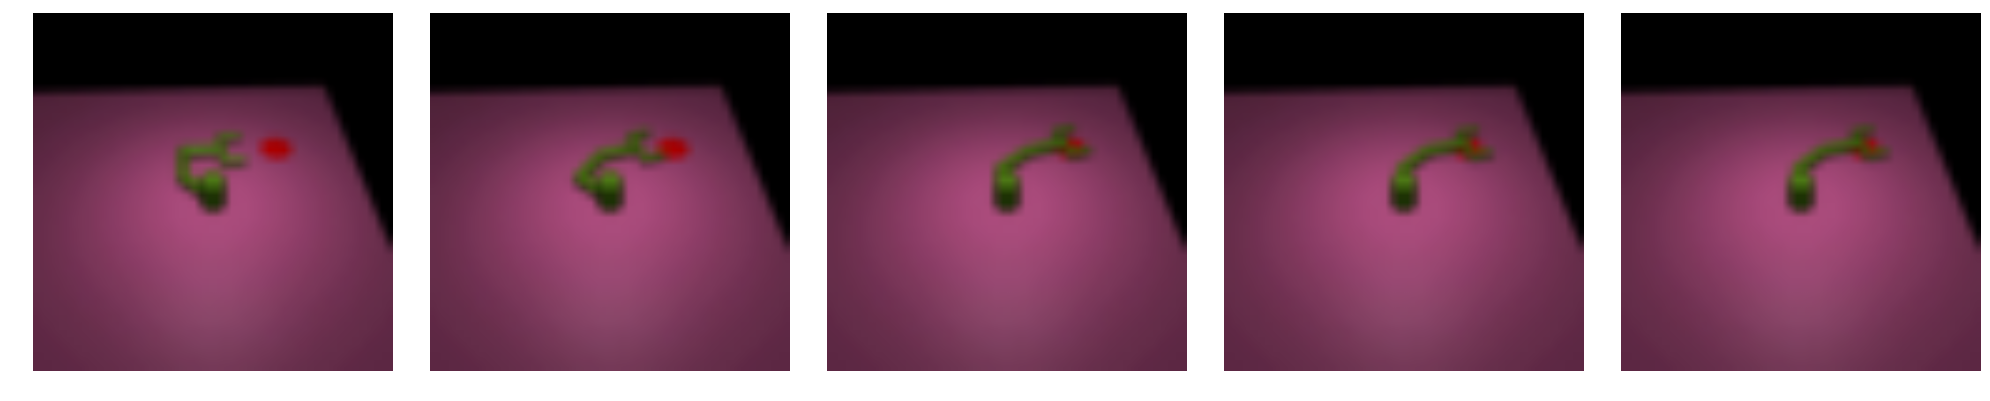

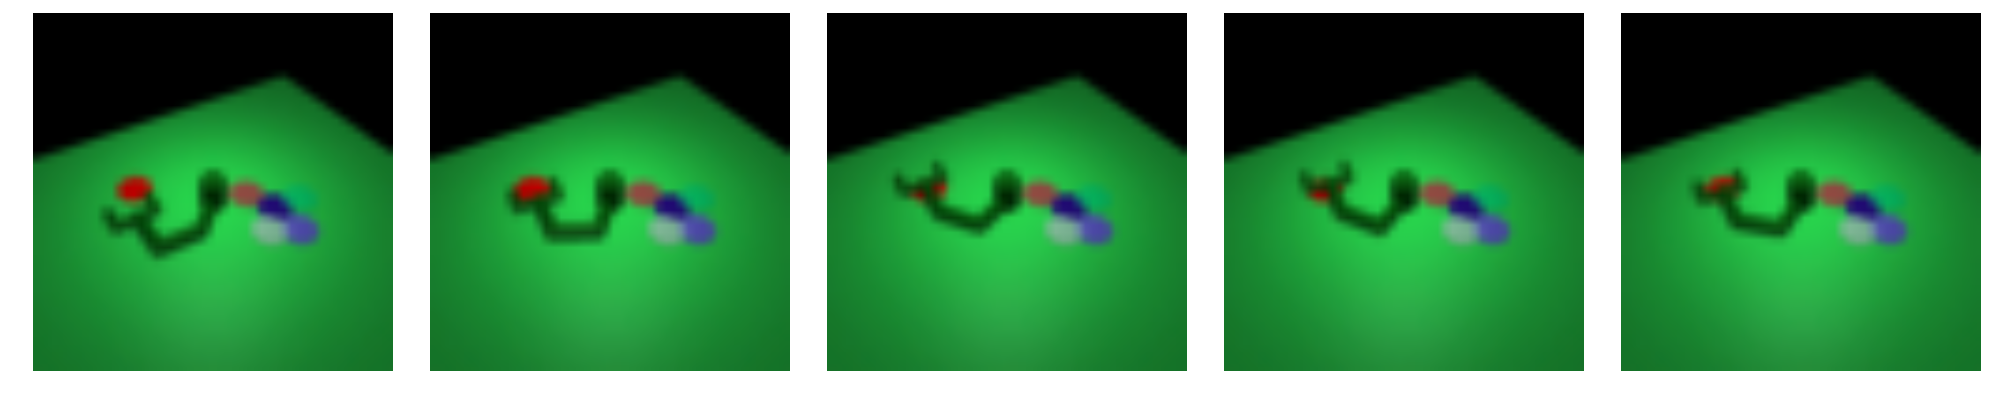

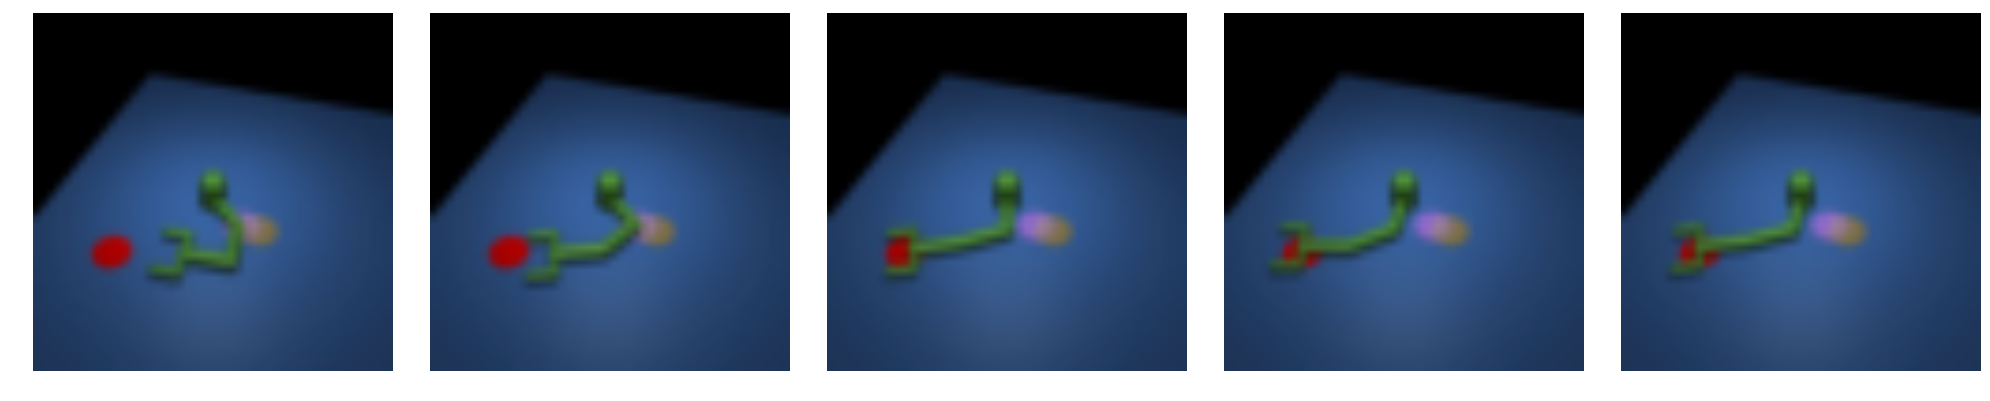

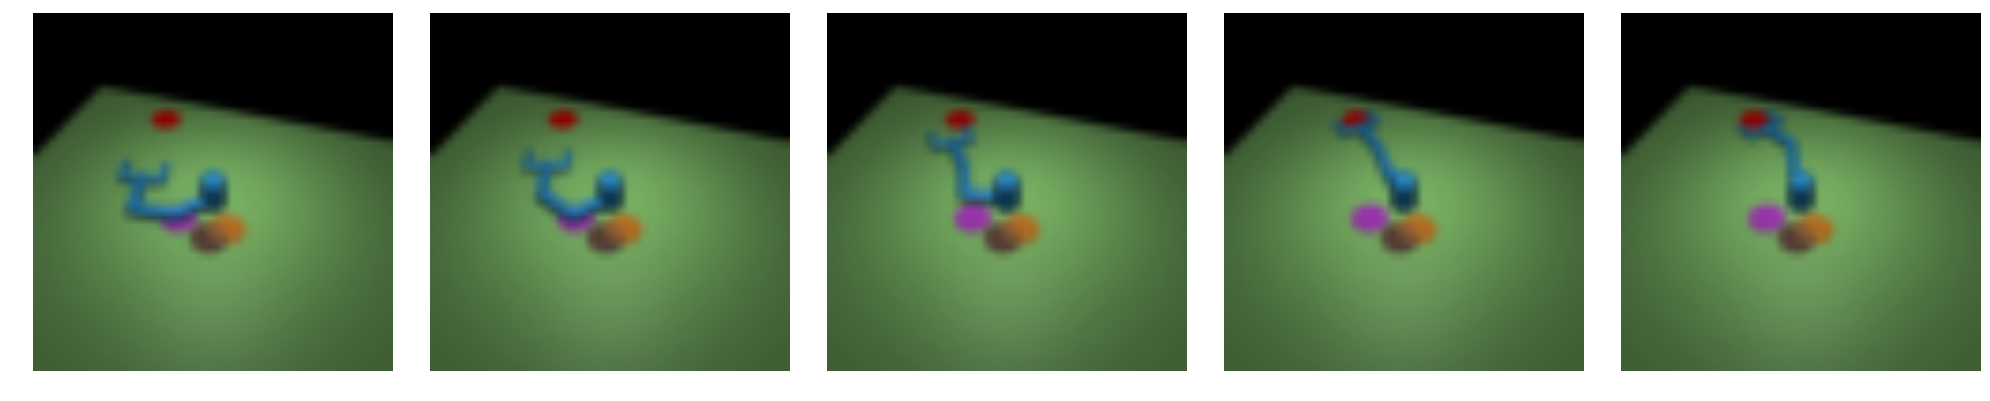

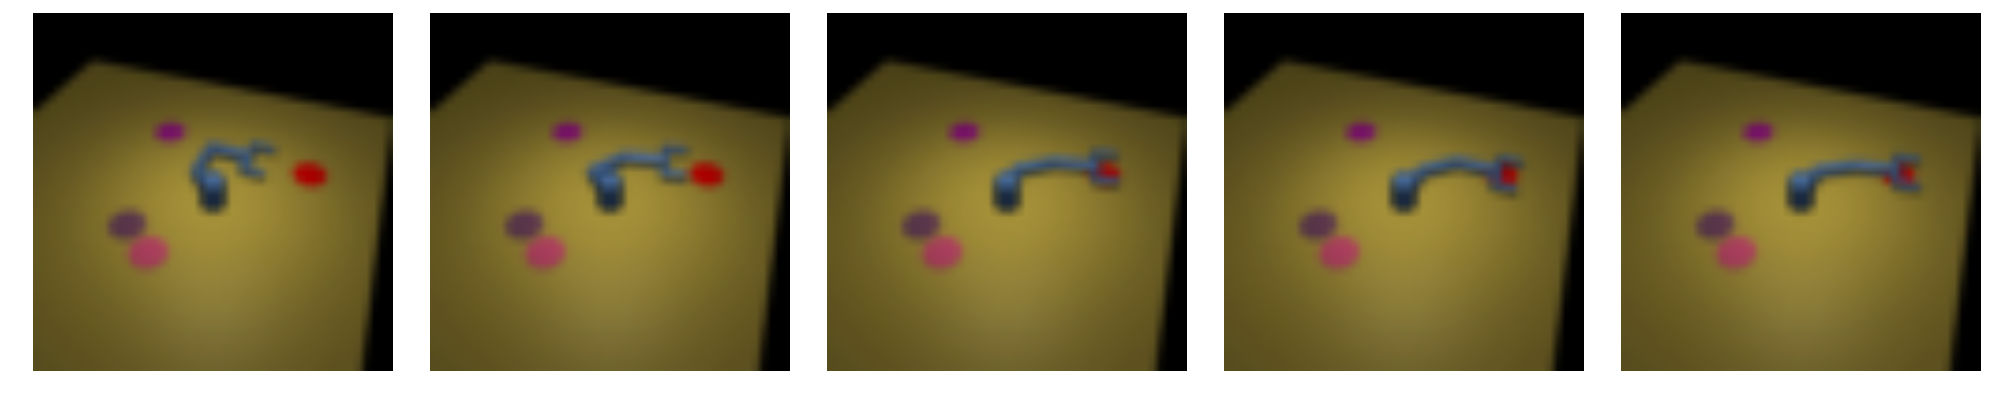

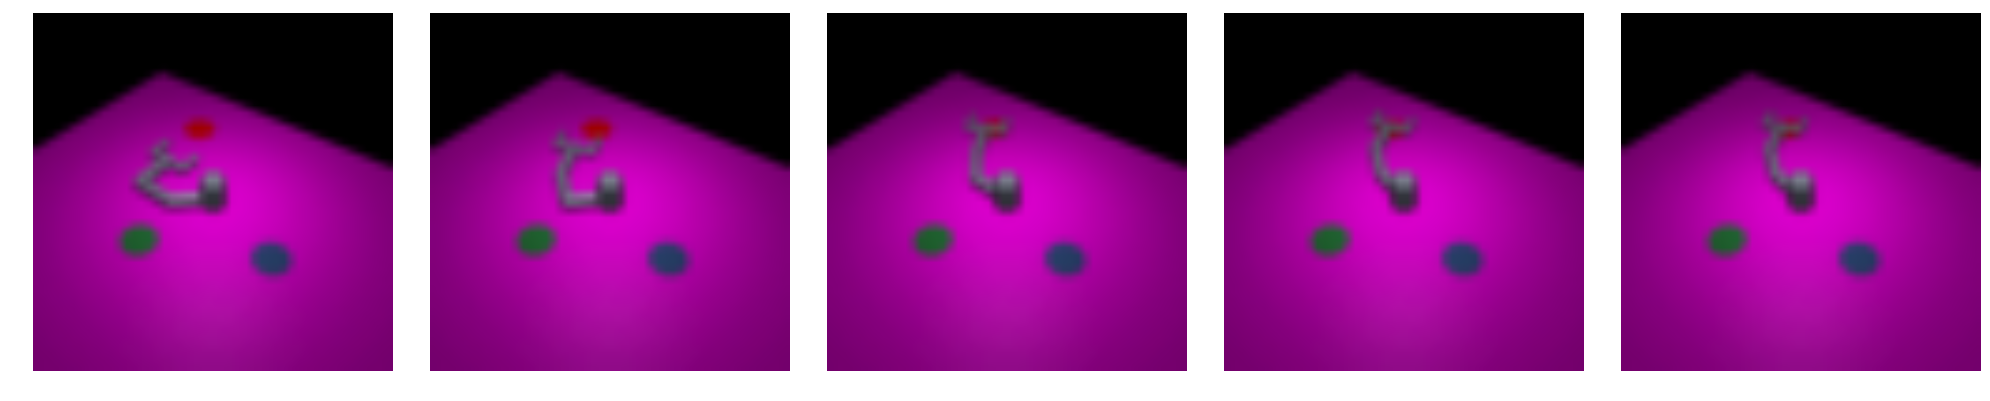

In [18]:
for i in range(10):
    filmstrip(traindata[np.arange(0, 25), i], 'fig/reach%d.jpg'%i)

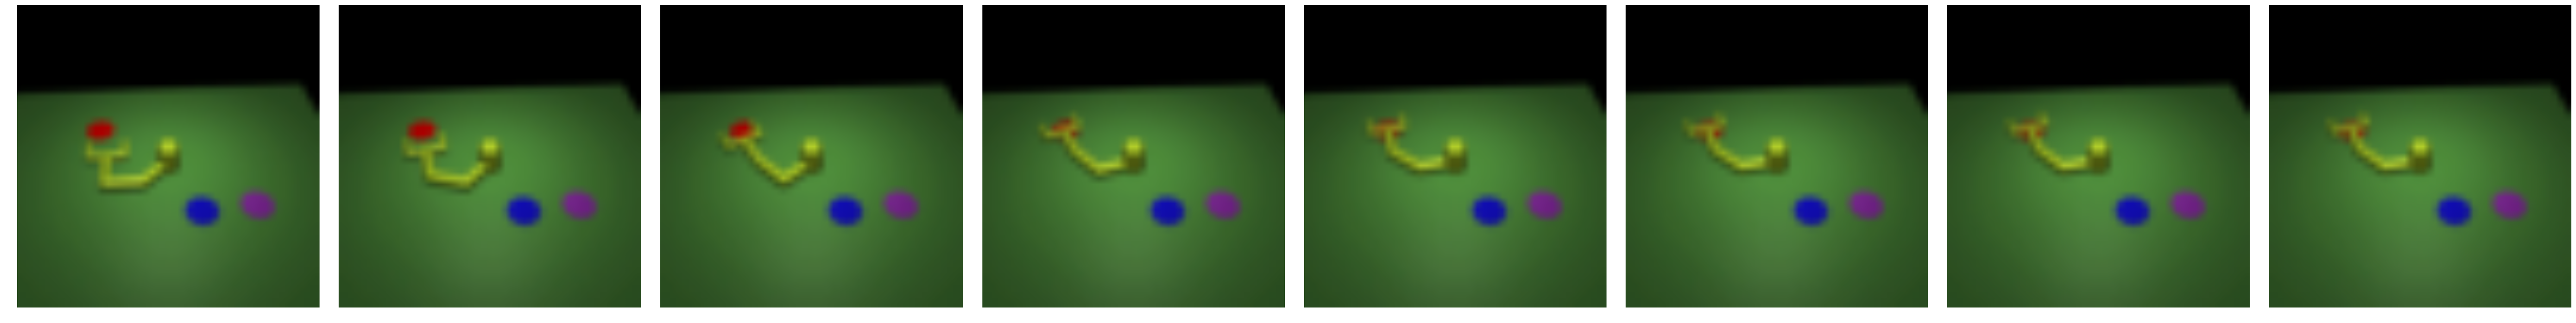

In [22]:
skip = 3
fig, ax = plt.subplots(nrows=1, ncols=25//skip, figsize=(50,10))
for i in range(25//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(tgtdata[i*skip]))
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

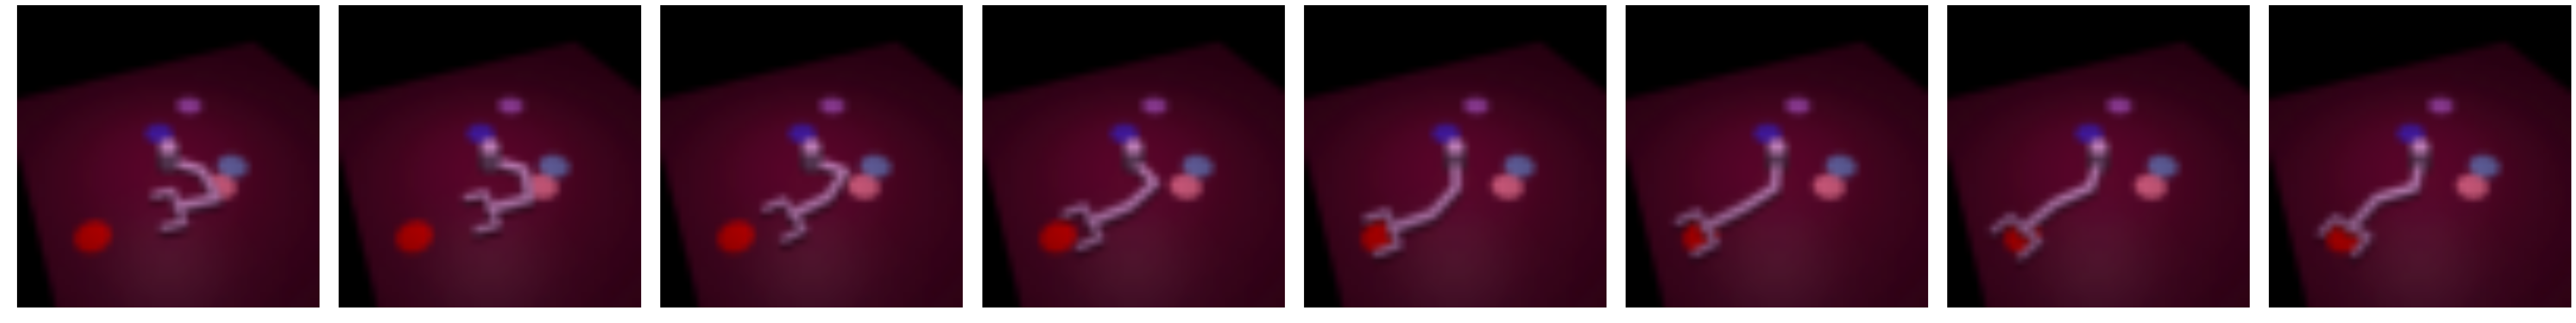

In [23]:
skip = 3
fig, ax = plt.subplots(nrows=1, ncols=25//skip, figsize=(50,10))
for i in range(25//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(srcdata[i*skip]))
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

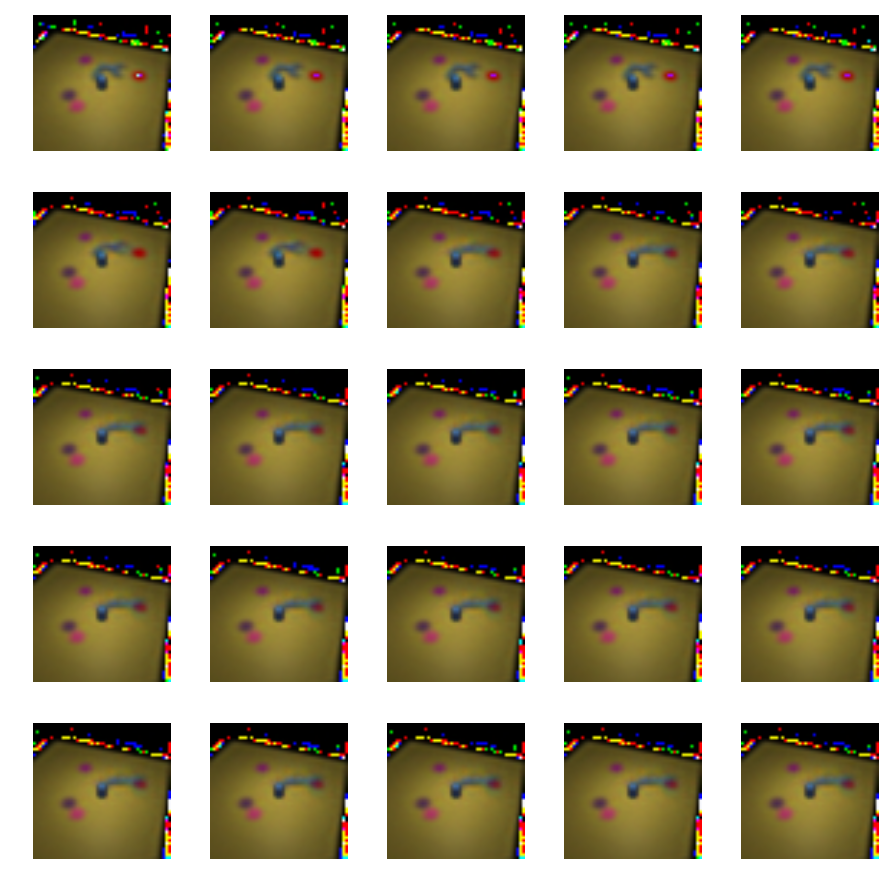

In [14]:
choicesrc = np.random.choice(ntrain, batch_size)
choicetgt = [8] * batch_size
srcdata = traindata[np.arange(0, batch_size) % 25, choicesrc]
tgtdata = traindata[np.arange(0, batch_size) % 25, choicetgt]
tgtctx = traindata[0, choicetgt]
batch = [srcdata, tgtctx, tgtdata]

testouts= sess.run(test.out, {tfinput: batch, tftrain: False})

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))

In [78]:
nvalid

4828

In [26]:
feats = []
for i in range(nvalid):
    if i % 100 == 0:
        print(i)
    choicesrc = [i] * batch_size
    choicetgt = [1] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    feats.append(sess.run( test.translated_z, 
        {tftrain: False, tfinput: batch})[:25])

0
100
200
300
400
500


In [27]:
tffeats = np.array(feats)
tffeats.shape

(594, 25, 1024)

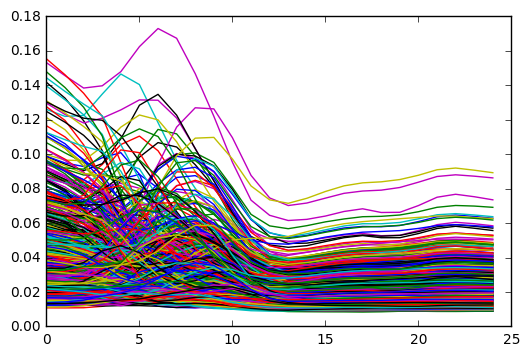

In [28]:
_=plt.plot(np.std(tffeats, axis=0))

In [29]:
means = np.mean(tffeats, axis=0)
means.shape

(25, 1024)

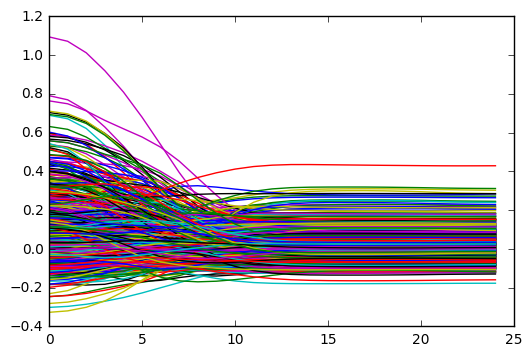

In [30]:
_=plt.plot(means)

In [84]:
np.save('ctxfeatsdistract250', means)

In [36]:
#name= '/home/andrewliu/research/viewpoint/rllab/data/local/trpo-push-res-translate/trpo_push_res_translate_2017_04_04_17_26_15_0001/gym_log/openaigym.video.0.26115.video004000.mp4'
name= '/home/andrewliu/research/viewpoint/rllab/data/local/trpo-push-start-goal-vp-vanilla/trpo_push_start_goal_vp_vanilla_2017_04_08_21_51_29_0001/gym_log/openaigym.video.0.14270.video001000.mp4'
vid = imageio.get_reader(name,  'ffmpeg')
if len(vid) == 51:
    frames = []
    for j in range(1, 51, 2):
        frame = transform(vid.get_data(j))
        if np.max(frame) == -1:
            print("rip", itr, name)
            frames = []
            break
        frames.append(frame)
frames = np.array(frames)

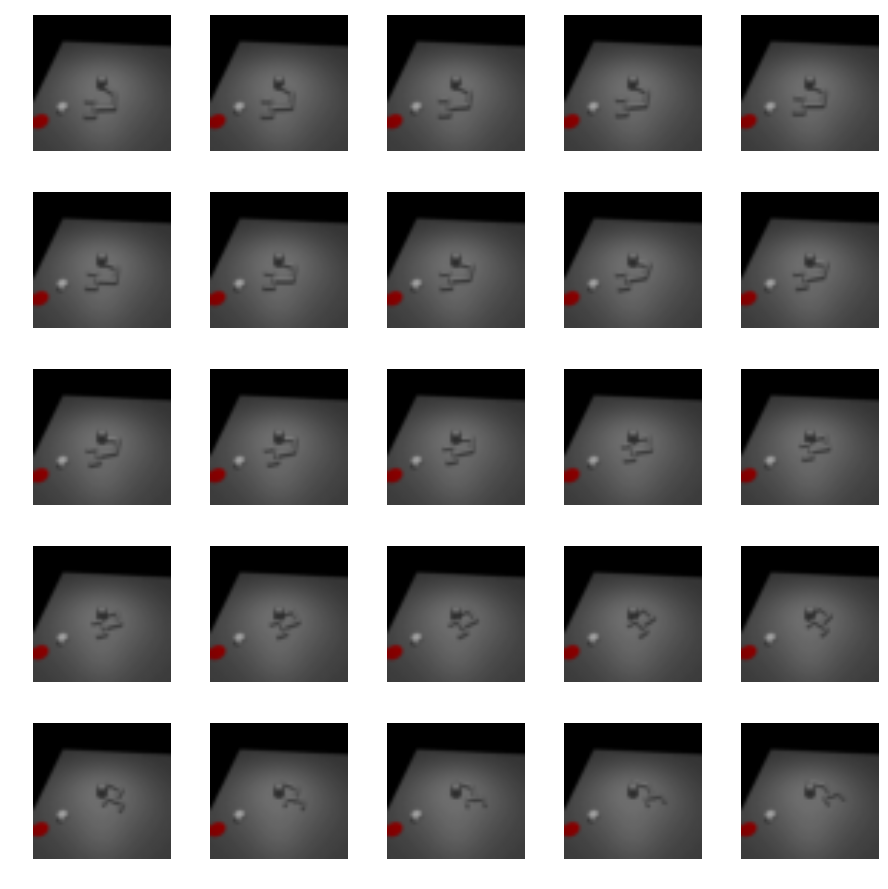

In [37]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(frames[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))

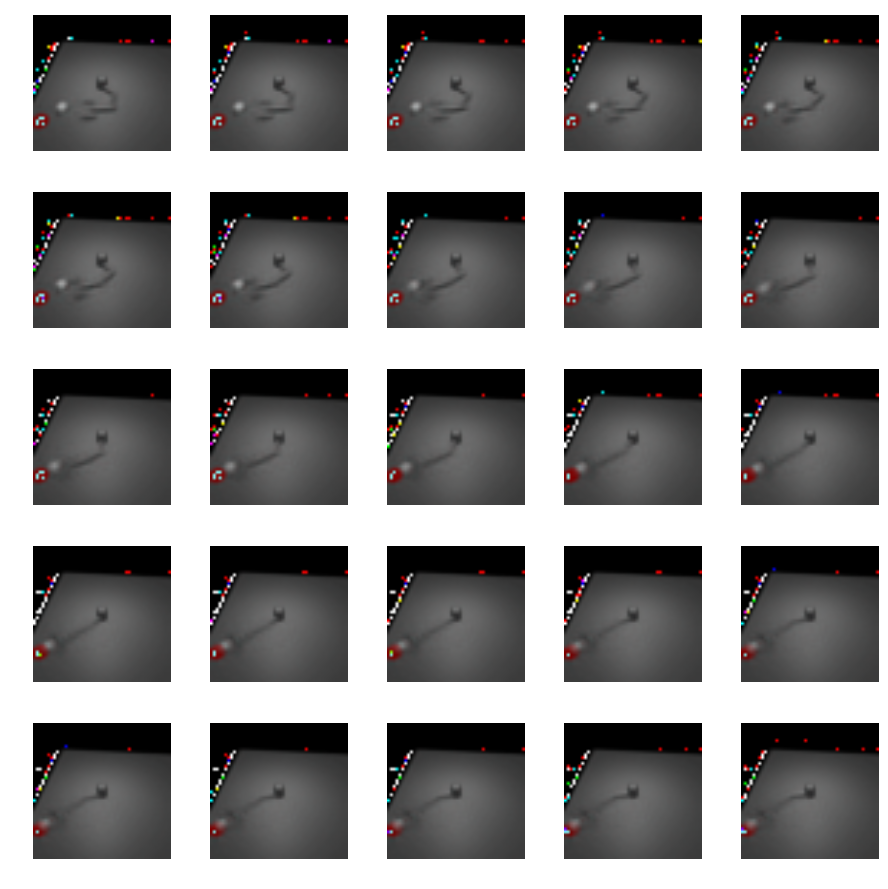

In [39]:
srcdata = frames[np.arange(0, batch_size) % 25]
tgtdata = srcdata
tgtctx = frames[[0] * batch_size]
batch = [srcdata, tgtctx, tgtdata]

testouts= sess.run(test.out, {tfinput: batch, tftrain: False})

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))